# Doppler shift maps
## Tutorial / explanation on how I got to the function shift_correction2nd
## Adapted for files of SPICE SOOP Mosaic of March 2nd
### First question : Doppler maps demonstrate always a shift that seemed inherent to the data. I tried here to model at the same time the differential rotation of the Sun and the fact that SPICE is moving while taking the rasters, using an empirical approach that should fit all the data.

In [4]:
# Import the packages we will need.
import os.path
import numpy as np
from sunraster.instr.spice import read_spice_l2_fits
import matplotlib.pyplot as plt

from astropy.modeling import models, fitting
from specutils.fitting import estimate_line_parameters
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from scipy.ndimage import median_filter

from tqdm.notebook import tqdm_notebook
import pickle
import warnings 
from copy import deepcopy
warnings.filterwarnings("ignore")

from specutils.fitting import fit_lines
from specutils.spectra import Spectrum1D
import EMToolKit.instruments.spice_functions_abundance as sfab
from EMToolKit.instruments.spice import contribution_func_spice
from mpl_toolkits.axes_grid1 import AxesGrid
plt.rcParams['image.origin'] = 'lower'
plt.rcParams.update({'font.size': 16}) # Make the fonts in figures big enough for papers
plt.rcParams.update({'figure.figsize':[15,7]})

dict_keys(['O III 703 / Mg IX 706 - SH', 'O III 703 / Mg IX 706 - LH', 'S IV 750/ Mg IX (spectral bin 2)', 'N IV 765 - Peak', 'Ne VIII 770 / Mg VIII 772 - SH', 'Ne VIII 770 / Mg VIII 772 - LH', 'S V 786 / O IV 787 - Extend', 'S IV 748 - Extended', 'S V 786 / O IV 787 - LW', 'N III 991 - SH', 'N III 991 - LH', 'O VI 1032 - Peak'])


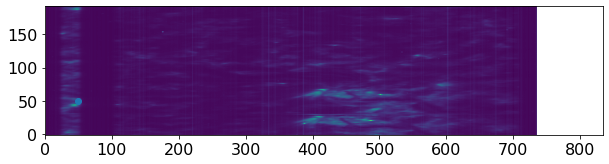

In [5]:
# Define the path where the SPICE FITS files are located.
# Replace this with the location where you stored the FITS files.
data_path = "mosaic"
filename = "solo_L2_spice-n-ras_20220302T004014_V03_100663682-000.fits"
file = os.path.join(data_path, filename)
# Read file.
exposure = read_spice_l2_fits(file,memmap=False)
print(exposure.keys())
plt.figure(figsize=[10,4])
plt.imshow(exposure['O VI 1032 - Peak'].data[0,10,:,:].T)
plt.plot(50,50, 'o')
plt.show()
raster = exposure['O VI 1032 - Peak']

In [6]:
def bindown(d,n):
    inds = np.ravel_multi_index(np.floor((np.indices(d.shape).T*n/np.array(d.shape))).T.astype(np.uint32),n)
    return np.bincount(inds.flatten(),weights=d.flatten(),minlength=np.prod(n)).reshape(n)
def substract_min_cube(cube):
    det_plane_min = np.nanmin(cube,axis=0)
    for i in range(0,cube.shape[0]): 
        cube[i,:,:] -= det_plane_min
    return cube

## Compute the shifts for only one line using single Gaussian fitting

In [30]:
keys = ['Ne VIII 770 / Mg VIII 772 - SH']
#set the errors parameters
shotnoise_fac = 0.025*np.sqrt(10)
noisefloor = 0.07

pxsz_mu = 18
platescale_x = pxsz_mu/1.1 # Micron per arcsecond
platescale_y = pxsz_mu/1.1 # Micron per arcsecond
platescale_l = pxsz_mu/0.09 # Micron per Angstrom

bin_facs = np.array([1, 2, 1])

tot_fit_amps = []
tot_errors = []
tot_chi2 = []
tot_cens = []
tot_sigs = []

tot_fit_amps_const = []
tot_errors_const = []
tot_chi2_const = []


for key in tqdm_notebook(keys) :
    raster = exposure[key]
    raster_yl = 100 #raster.data[0,15,:,:].shape[0]
    raster_yh = 711 #raster.data[0,15,:,:].shape[1]
    #downsize the raster
    cube = raster[0].data.transpose([2,1,0])
    cube = substract_min_cube(cube)
    print(cube.shape)
    wl0 = (raster.meta.original_header['CRVAL3']-raster.meta.original_header['CDELT3']*raster.meta.original_header['CRPIX3'])*10
    det_scale0 = bin_facs*np.array([raster.meta.original_header['CDELT1']*platescale_x,
                                raster.meta.original_header['CDELT2']*pxsz_mu,10*raster.meta.original_header['CDELT3']*platescale_l])
    det_origin0 = np.array([0.0,0.0,wl0*platescale_l])
    det_dims0 = np.array(cube.shape)
    waves = (det_origin0[2]+np.arange(det_dims0[2])*det_scale0[2])/platescale_l
    wcen0 = waves[np.nanargmax(np.nansum(np.nansum(cube,axis=0),axis=0))]

    #reduce the size of the raster
    raster = bindown(cube,np.round(np.array(cube.shape)/bin_facs).astype(np.int32))
    print('Size binned down : ', raster.shape)
    #mask and filter
    dat_arr = raster
    dat_filt = median_filter(dat_arr,size=3)
    filt_thold = 0.5
    sig0 = 0.3*u.Angstrom
    cen0 = wcen0*u.Angstrom
    dat_median = np.nanmedian(np.abs(dat_filt))
    dat_mask = (np.isnan(dat_arr) + np.isinf(dat_arr) +
                (np.abs(dat_arr-dat_filt) > filt_thold*(dat_median+np.abs(dat_filt)))+ (dat_arr < - 0.0)) > 0

    #Initialization of arrays for storing fit parameters
    [nx,ny] = raster.shape[0:2]
    errors = ((noisefloor**2+np.abs(dat_filt)*shotnoise_fac**2)**0.5).astype('float32')
    fit_amps = np.zeros([nx,ny])
    fit_cen = np.zeros([nx,ny])
    fit_sigs = np.zeros([nx,ny])
    fit_err = np.zeros([nx,ny])
    fit_chi2 = np.zeros([nx,ny])
    
    fit_amps_const = np.zeros([nx,ny])
    fit_err_const = np.zeros([nx,ny])
    fit_chi2_const = np.zeros([nx,ny])


    for i in tqdm_notebook(range(0,nx)):
        for j in range(0,ny):
            data = raster[i, j, :]*u.adu
            errs = errors[i, j, :]
            mask = dat_mask[i, j, :]

            if(np.sum(np.logical_not(mask)) > 10):
                dat = data[np.logical_not(mask)].value
                wvl =  waves[np.logical_not(mask)]*u.Angstrom
                cont = np.min(dat)
                wav_norm = np.trapz(dat-cont,x=wvl)
                #amplitude, center and sigma guesses 
                amp = np.max(dat)-cont #np.trapz(dat-cont,x=wvl)
                cen = np.clip(np.trapz(wvl*(dat-cont),x=wvl)/wav_norm,cen0-sig0,cen0+sig0)
                sig =np.clip((np.trapz(wvl**2*(dat-cont),x=wvl)/wav_norm-cen**2),(0.25*sig0)**2,(2.5*sig0)**2)**0.5

                spec = Spectrum1D(flux = data, spectral_axis = waves*u.Angstrom, uncertainty=StdDevUncertainty(errs), mask=mask)

                g_init = models.Gaussian1D(amplitude=amp,
                       mean=cen,
                       stddev=sig, 
                       bounds={'amplitude':[0,np.max(dat)],
                               'mean':[np.min(waves),np.max(waves)],
                               'stddev':[waves[1]-waves[0],0.5*(waves[-1]-waves[0])]})
                c_init = models.Const1D(amplitude = noisefloor,
                                        bounds={'amplitude':[np.min(dat),np.max(dat)]})
        
                g_fit = fit_lines(spec, g_init + c_init)
                g_fit_const = fit_lines(spec, c_init)
                
                y_fit = g_fit(wvl) #waves*u.Angstrom
                y_fit_const = g_fit_const(wvl) #waves*u.Angstrom
                
                fit_amps[i][j] = g_fit.amplitude_0.value
                fit_amps_const[i][j] = g_fit_const.amplitude.value

                fit_sigs[i][j] = g_fit.stddev_0.value
                
                if 'Ne' in key :
                    fit_cen[i][j] = 770 - g_fit.mean_0.value 
                else :
                    fit_cen[i][j] = 1032 - g_fit.mean_0.value

                fit_err[i][j] = np.abs((g_fit.amplitude_0.value/np.nansum(data[mask==0].value))*
                                       np.sqrt(np.nansum((errs[mask==0])**2)))
                fit_err_const[i][j] = np.abs((g_fit_const.amplitude.value/np.nansum(data[mask==0].value))*
                       np.sqrt(np.nansum((errs[mask==0])**2)))
                fit_chi2[i][j] = np.nansum((dat-y_fit.value)**2/fit_err[i][j]**2)
                fit_chi2_const[i][j] = np.nansum((dat-y_fit_const.value)**2/fit_err_const[i][j]**2)
                
    tot_fit_amps.append(fit_amps)
    tot_errors.append(fit_err)
    tot_chi2.append(fit_chi2)
    tot_cens.append(fit_cen)
    tot_sigs.append(fit_sigs)

  0%|          | 0/1 [00:00<?, ?it/s]

(192, 834, 41)
Size binned down :  (192, 417, 41)


  0%|          | 0/192 [00:00<?, ?it/s]

# Estimation of Doppler inherent to SPICE : along solar X 

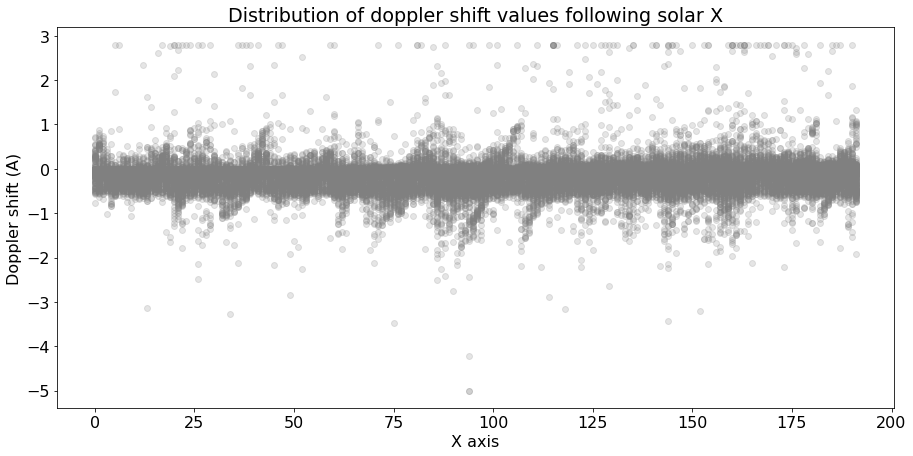

In [31]:
x = np.arange(0,tot_cens[0].shape[0])
for i in range(tot_cens[0].shape[1]):
    plt.scatter(x, tot_cens[0][:,i], color='gray', alpha=0.2)
plt.xlabel('X axis'), plt.ylabel('Doppler shift (A)')
plt.title('Distribution of doppler shift values following solar X');

In [32]:
import scipy
def func(x, a, b):
    return a*x+b

# Comparison with / without dumbbells

(Text(0.5, 1.0, 'Median of the shift values and fit'),
 <matplotlib.legend.Legend at 0x14500707e20>)

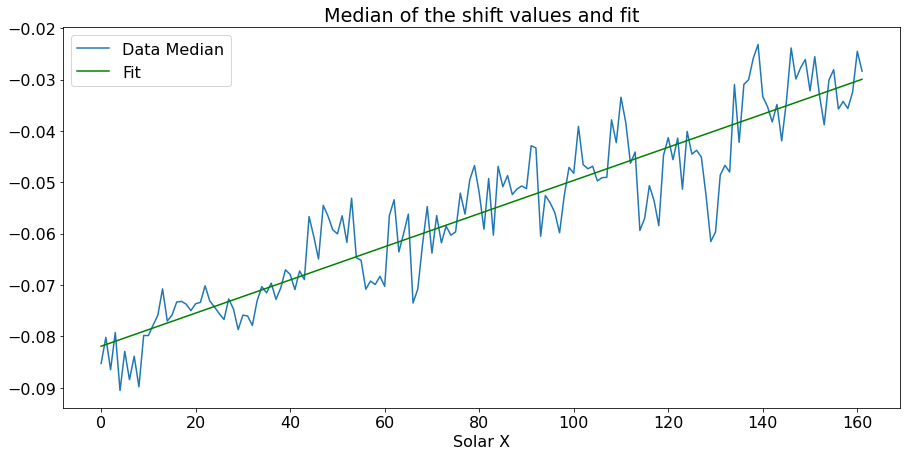

In [34]:
dopp_crop = tot_cens[0][30:,50:356]
x = np.arange(0,dopp_crop.shape[0])
plt.plot(x, np.median(dopp_crop,axis=1), label="Data Median")
popt,cov = scipy.optimize.curve_fit(func, x,np.median(dopp_crop,axis=1))
a,b= popt
plt.plot(func(x, a, b), color='green', label='Fit'), plt.xlabel('Solar X')
plt.title('Median of the shift values and fit'), plt.legend()

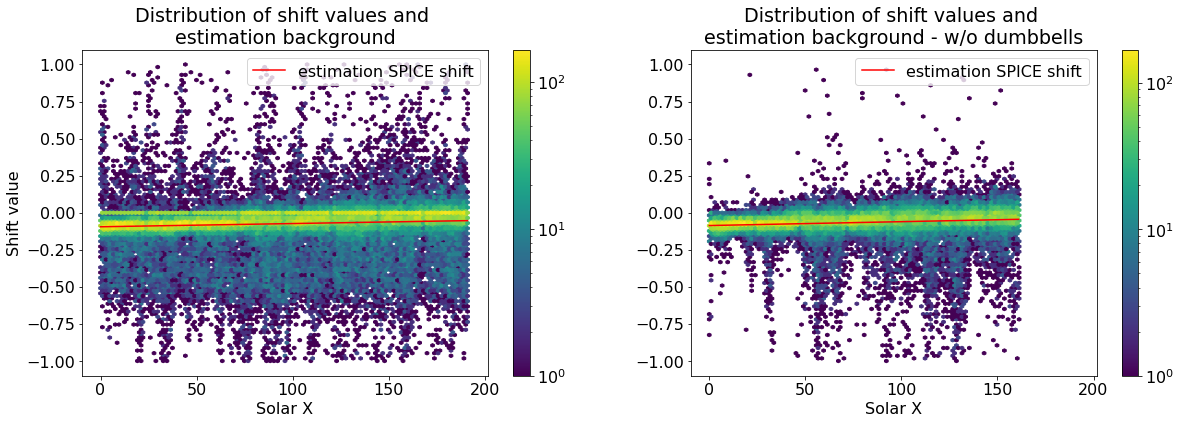

In [53]:
plt.figure(figsize=[20,6])
plt.subplot(121)
x = np.arange(0,tot_cens[0].shape[0])
plt.hexbin(np.array([x]*tot_cens[0].shape[1]).T, tot_cens[0], bins='log', extent=(0,192,-1,1))
plt.plot(func(x, np.median(list_a), np.median(list_b)), color='red', label='estimation SPICE shift')
plt.title('Distribution of shift values and \nestimation background'), plt.legend(), plt.ylabel('Shift value')
plt.xlabel('Solar X')
plt.colorbar()

plt.subplot(122)
x = np.arange(0,dopp_crop.shape[0])
plt.hexbin(np.array([x]*dopp_crop.shape[1]).T, dopp_crop, bins='log', extent=(0,192,-1,1))
plt.plot(func(x, np.median(list_a_crop), np.median(list_b_crop)), color='red', label='estimation SPICE shift')
plt.title('Distribution of shift values and \nestimation background - w/o dumbbells'), plt.legend()
plt.xlabel('Solar X')
plt.colorbar();

Text(0.5, 1.0, 'Influence of longitude on the estimation of Doppler Shifts')

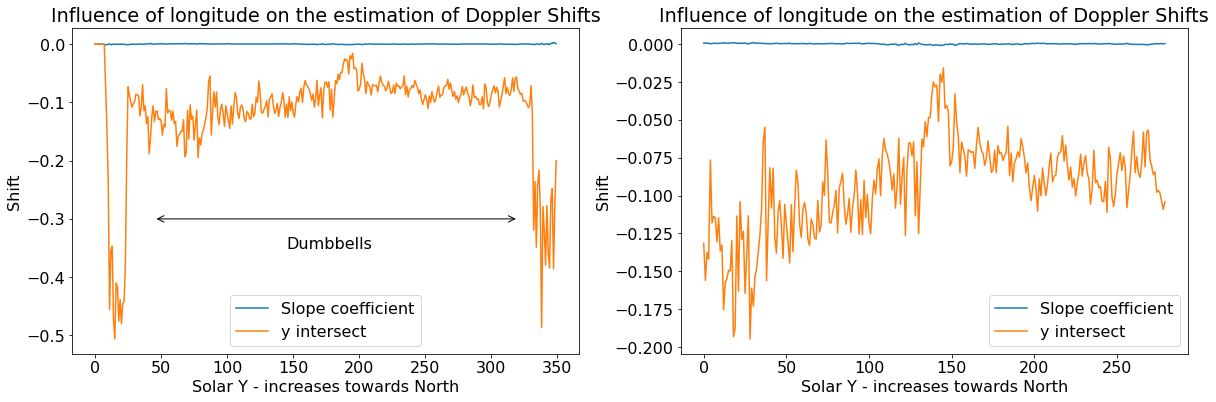

In [52]:
## Dependancy following Y axis
plt.figure(figsize=[20,6])
plt.subplot(121)
y = np.arange(0, tot_cens[0].shape[1])
plt.plot(y,list_a, label='Slope coefficient')
plt.plot(y,list_b, label='y intersect')
plt.xlabel('Solar Y - increases towards North')
plt.ylabel('Shift')
plt.annotate(text='', xy=(45,-0.3), xytext=(320,-0.3), arrowprops=dict(arrowstyle='<->'))
plt.text(145,-0.35, 'Dumbbells'), plt.legend()
plt.title('Influence of longitude on the estimation of Doppler Shifts')

plt.subplot(122)
y = np.arange(0, dopp_crop.shape[1])
plt.plot(y,list_a_crop, label='Slope coefficient')
plt.plot(y,list_b_crop, label='y intersect')
plt.xlabel('Solar Y - increases towards North')
plt.ylabel('Shift')
plt.legend()
plt.title('Influence of longitude on the estimation of Doppler Shifts')

In [134]:
x = np.arange(0,tot_cens[0][30:,50:330].shape[0])
tot_cens_corrected = deepcopy(tot_cens[0][30:,50:330])
for j in range(tot_cens[0][30:,50:330].shape[1]):
    tot_cens_corrected[:,j] -= func(x, np.mean(list_a_crop), np.mean(list_b_crop))

Text(0.5, 1.0, 'Difference')

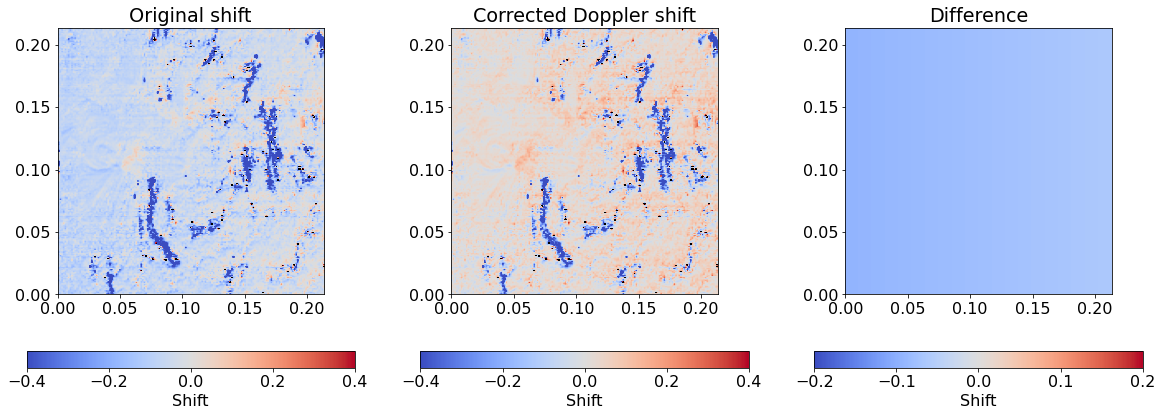

In [141]:
plt.figure(figsize=[20,7])
plt.subplot(131)
im = plt.imshow(tot_cens[0][30:,50:330].T, extent=extent, cmap=deepcopy(plt.cm.coolwarm))
cbar = plt.colorbar(im, location='bottom')
cbar.ax.set_xlabel('Shift')
im.cmap.set_over('k')
im.set_clim(-0.4, 0.4)
plt.title('Original shift')
plt.subplot(132)
im = plt.imshow(tot_cens_corrected.T, extent=extent, cmap=deepcopy(plt.cm.coolwarm))
cbar = plt.colorbar(im, location='bottom')
cbar.ax.set_xlabel('Shift')
im.cmap.set_over('k')
im.set_clim(-0.4, 0.4)
plt.title('Corrected Doppler shift')
plt.subplot(133)
im = plt.imshow(tot_cens[0][30:,50:330].T-tot_cens_corrected.T, extent=extent, cmap=deepcopy(plt.cm.coolwarm))
cbar = plt.colorbar(im, location='bottom')
cbar.ax.set_xlabel('Shift')
im.cmap.set_over('k')
im.set_clim(-0.2, 0.2)
plt.title('Difference')

# Effect of Solar differential rotation on plots
### Find A, B, C as $\omega=A+B\,\sin^2(\varphi)+C\,\sin^4(\varphi)$

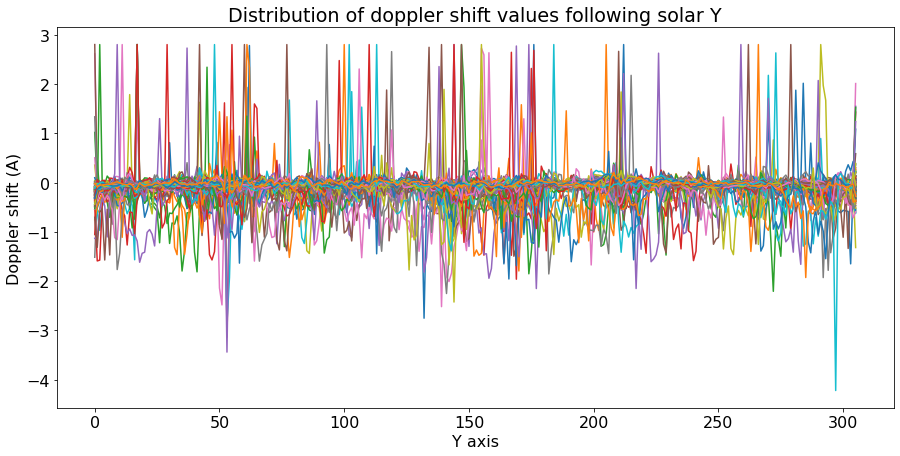

In [19]:
xlat = np.arange(0,tot_cens[0].shape[1])
for i in range(tot_cens[0].shape[0]):
    plt.plot(xlat, tot_cens[0][i,:])
plt.xlabel('Y axis'), plt.ylabel('Doppler shift (A)')
plt.title('Distribution of doppler shift values following solar Y');

def func(x, a, b):
    return a*x + b
def func_lat(phi, A, B, C):
    return A + B*np.sin(phi)**2+C*np.sin(phi)**4

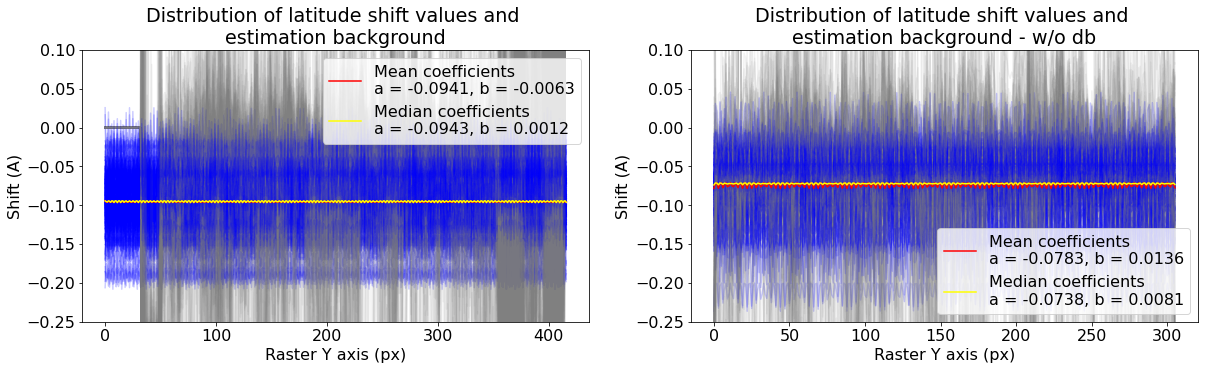

In [43]:
xlat = np.arange(0,tot_cens[0].shape[1])
plt.figure(figsize=[20,5])
plt.subplot(121)
list_a = []
list_b = []
list_c = []
for i in range(tot_cens[0].shape[0]):
    plt.plot(xlat, tot_cens[0][i,:], color='gray', alpha=.1)
    popt,cov = scipy.optimize.curve_fit(func_lat, xlat, tot_cens[0][i,:])
    a,b,c = popt
    list_a.append(a)
    list_b.append(b)
    list_c.append(c)
    plt.plot(xlat ,func_lat(xlat, a, b, c),color="blue", alpha=.2)
plt.ylim(-0.25,0.1), plt.ylabel('Shift (A)'), plt.xlabel('Raster Y axis (px)')
plt.plot(func_lat(xlat, np.mean(list_a), np.mean(list_b), np.mean(list_c)), color='red', 
         label='Mean coefficients \na = '+str("%.4f" % np.mean(list_a)) + ', b = ' +str ("%.4f" % np.mean(list_b)))
plt.plot(func_lat(xlat, np.median(list_a), np.median(list_b), np.median(list_c)), color='yellow',
         label='Median coefficients \na = '+str("%.4f" % np.median(list_a)) + ', b = ' +str ("%.4f" % np.median(list_b)))
plt.title('Distribution of latitude shift values and \nestimation background')
plt.legend();

plt.subplot(122)
list_al = []
list_bl = []
list_cl = []
xlat = np.arange(0,dopp_crop.shape[1])
for i in range(tot_cens[0][30:,50:356].shape[0]):
    plt.plot(xlat, tot_cens[0][30:,50:356][i,:], color='gray', alpha=.1)
    popt,cov = scipy.optimize.curve_fit(func_lat, xlat, tot_cens[0][30:,50:356][i,:])
    a,b,c = popt
    list_al.append(a)
    list_bl.append(b)
    list_cl.append(c)
    plt.plot(xlat ,func_lat(xlat, a, b, c),color="blue", alpha=.2)
plt.ylim(-0.25,0.1), plt.ylabel('Shift (A)'), plt.xlabel('Raster Y axis (px)')
plt.plot(func_lat(xlat, np.mean(list_al), np.mean(list_bl), np.mean(list_cl)), color='red', 
         label='Mean coefficients \na = '+str("%.4f" % np.mean(list_al)) + ', b = ' +str ("%.4f" % np.mean(list_bl)))
plt.plot(func_lat(xlat, np.median(list_al), np.median(list_bl), np.median(list_cl)), color='yellow',
         label='Median coefficients \na = '+str("%.4f" % np.median(list_al)) + ', b = ' +str ("%.4f" % np.median(list_bl)))
plt.title('Distribution of latitude shift values and \nestimation background - w/o db')
plt.legend();

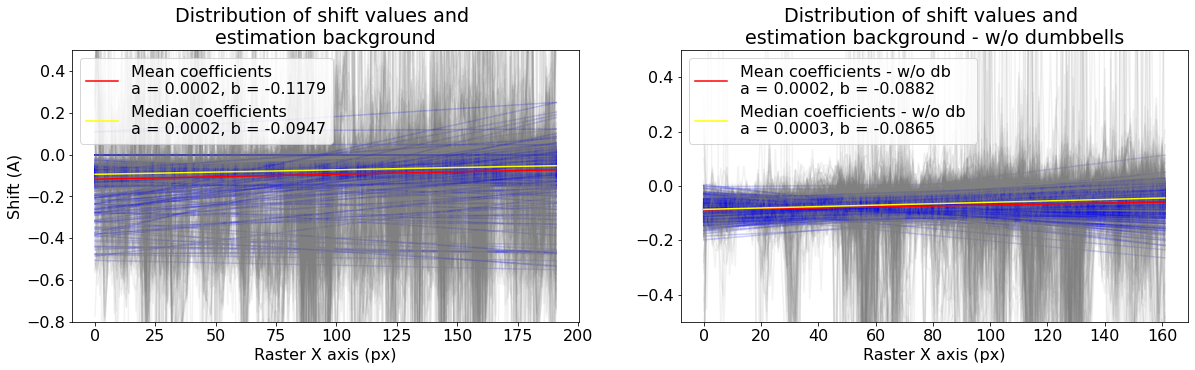

In [44]:
x = np.arange(0,tot_cens[0].shape[0])
plt.figure(figsize=[20,5])
plt.subplot(121)
list_a = []
list_b = []
for i in range(tot_cens[0].shape[1]):
    plt.plot(x, tot_cens[0][:,i], color='gray', alpha=.1)
    popt,cov = scipy.optimize.curve_fit(func, x, tot_cens[0][:,i])
    a,b= popt
    list_a.append(a)
    list_b.append(b)
    plt.plot(x,func(x, a, b),color="blue", alpha=.2)
plt.ylim(-0.8,0.5), plt.ylabel('Shift (A)'), plt.xlabel('Raster X axis (px)')
plt.plot(func(x, np.mean(list_a), np.mean(list_b)), color='red', 
         label='Mean coefficients \na = '+str("%.4f" % np.mean(list_a)) + ', b = ' +str ("%.4f" % np.mean(list_b)))
plt.plot(func(x, np.median(list_a), np.median(list_b)), color='yellow',
         label='Median coefficients \na = '+str("%.4f" % np.median(list_a)) + ', b = ' +str ("%.4f" % np.median(list_b)))
plt.title('Distribution of shift values and \nestimation background')
plt.legend();

plt.subplot(122)
x = np.arange(0,tot_cens[0][30:,50:356].shape[0])
list_a_crop = []
list_b_crop = []
for i in range(dopp_crop.shape[1]):
    plt.plot(x, dopp_crop[:,i], color='gray', alpha=.1)
    popt,cov = scipy.optimize.curve_fit(func, x, dopp_crop[:,i])
    a,b= popt
    list_a_crop.append(a)
    list_b_crop.append(b)
    plt.plot(x,func(x, a, b),color="blue", alpha=.2)
plt.ylim(-0.5,0.5), plt.xlabel('Raster X axis (px)')
plt.plot(func(x, np.mean(list_a_crop), np.mean(list_b_crop)), color='red',
         label='Mean coefficients - w/o db \na = '+str("%.4f" % np.mean(list_a_crop)) + ', b = ' +str ("%.4f" % np.mean(list_b_crop)))
plt.plot(func(x, np.median(list_a_crop), np.median(list_b_crop)), color='yellow',
         label='Median coefficients - w/o db \na = '+str("%.4f" % np.median(list_a_crop)) + ', b = ' +str ("%.4f" % np.median(list_b_crop)))
plt.title('Distribution of shift values and \nestimation background - w/o dumbbells')
plt.legend(), plt.show();

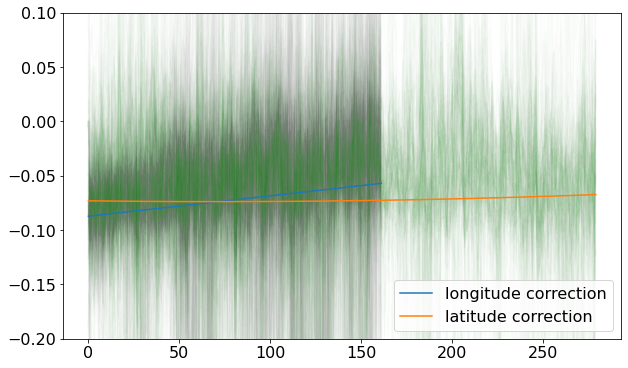

In [173]:
plt.figure(figsize=[10,6])
for i in range(dopp_crop.shape[1]):
    plt.plot(x, dopp_crop[:,i], color='gray', alpha=.01)
for j in range(dopp_crop.shape[0]):
    plt.plot(xlatc, dopp_crop[j,:], color='green', alpha=.01)
plt.plot(x, func(x, np.mean(list_a_crop), np.mean(list_b_crop)), label='longitude correction'), plt.ylim(-0.2,0.1)
plt.plot(xlatc, func2(xlatc, np.mean(list_a_cropl), np.mean(list_b_cropl), np.mean(list_c_cropl)),label='latitude correction'), plt.ylim(-0.2,0.1)
plt.legend();plt.show()

In [210]:
def func_lat(A, B, C, phi):
    return A + B*np.sin(phi)**2+C*np.sin(phi)**4

## Final function correcting maps on latitude and longitude

In [108]:
def shift_correction2nd(array_doppler, cropped = False, crop82 = False, plot_detail=False):
    from scipy.optimize import curve_fit
    import numpy as np
    from copy import deepcopy
    
    if crop82 == False :
        array_doppler = array_doppler[30:,50,356]
    if cropped == False : 
        array_doppler = array_doppler[:,50,356]
    
    #1 degree model for longitude correction
    def func(x, a, b) :
        return a*x + b
    xlon = (np.arange(0, array_doppler.shape[0])*1.09)/3600 #get the x in degrees
    
    lista_lon = []
    listb_lon = []
    listerr_lon = []
    # Correct the longitude effect
    for i in range(array_doppler.shape[1]):
        popt, pcov = curve_fit(func, xlon, array_doppler[:,i])
        a,b = popt
        lista_lon.append(a)
        listb_lon.append(b)
        #error of the fit
        perr = np.sqrt(np.diag(pcov))
        listerr_lon.append(perr)
    
    # Latitude correction (differential rotation sun)
    def func_lat(phi, A, B, C):
        return A + B*np.sin(phi)**2+C*np.sin(phi)**4
    listA_lat = []
    listB_lat = []
    listC_lat = []
    listerr_lat = []
    #Correct the latitude effect
    xlat = (np.arange(0, array_doppler.shape[1])*4)/3600
    for i in range(array_doppler.shape[0]):
        poptlat, pcovlat = curve_fit(func_lat, xlat, array_doppler[i,:])
        A, B, C = poptlat
        listA_lat.append(A)
        listB_lat.append(B)
        listC_lat.append(C)
        #error of the fit
        perrlat = np.sqrt(np.diag(pcovlat))
        listerr_lat.append(perrlat)
    
    # Build the new array of corrected shifts
    corr_doppler = deepcopy(array_doppler)
    for j in range(array_doppler.shape[0]):
        corr_doppler[j,:] -= func_lat(xlat, np.mean(listA_lat),
                                  np.mean(np.mean(listB_lat)), np.mean(listC_lat))
    for j in range(array_doppler.shape[1]):
        corr_doppler[:,j] -= func(xlon, np.mean(lista_lon), np.mean(listb_lon))
        
    # Plot the corrected shift
    plt.figure(figsize=[16,6])
    plt.subplot(1,3,1)
    im = plt.imshow(corr_doppler.T-np.median(corr_doppler),
                    extent = [0, corr_doppler.shape[0]*4, 0, 1.1*2*corr_doppler.shape[1]],
                    cmap=deepcopy(plt.cm.coolwarm))
    cbar = plt.colorbar(im, location='bottom')
    cbar.ax.set_xlabel('Shift')
    im.cmap.set_over('white'), im.cmap.set_under('white')
    im.set_clim(-np.nanquantile(corr_doppler,0.9), np.nanquantile(corr_doppler,0.9))
    plt.title('Corrected Doppler shift'), plt.xlabel('Longitude axis (arcsec)'), plt.ylabel('Latitude axis (arcsec)')

    plt.subplot(1,3,2)
    im = plt.imshow(array_doppler.T,
                    extent = [0, corr_doppler.shape[0]*4, 0, 1.1*2*corr_doppler.shape[1]],
                    cmap=deepcopy(plt.cm.coolwarm))
    cbar = plt.colorbar(im, location='bottom')
    cbar.ax.set_xlabel('Shift')
    im.cmap.set_over('white'), im.cmap.set_under('white')
    im.set_clim(-np.nanquantile(corr_doppler,0.85), np.nanquantile(corr_doppler,0.85))
    plt.title('Original Doppler shift'), plt.xlabel('Longitude axis (arcsec)')
    
    plt.subplot(1,3,3)
    diff = array_doppler.T-(corr_doppler.T-np.median(corr_doppler))
    im = plt.imshow(diff,
                    extent = [0, corr_doppler.shape[0]*4, 0, 1.1*2*corr_doppler.shape[1]],
                    cmap=deepcopy(plt.cm.coolwarm))
    cbar = plt.colorbar(im, location='bottom')
    cbar.ax.set_xlabel('Shift')
    im.cmap.set_over('white'), im.cmap.set_under('white')
    im.set_clim(np.nanquantile(diff,0), np.nanquantile(diff,1))
    plt.title('Difference'), plt.xlabel('Longitude axis (arcsec)')
    plt.show()
    
    # Optionnal : plot the estimation curves
    if plot_detail : 
        plt.figure(figsize=[10,6])
        for i in range(array_doppler.shape[1]):
            plt.scatter(xlon, array_doppler[:,i], color='gray', alpha=.01)
        plt.plot(xlon, func(xlon, np.mean(lista_lon), np.mean(listb_lon)), label='Longitude correction'), plt.ylim(-0.2,0.1)
        plt.legend(); plt.xlabel('Longitude axis (degrees)'); plt.ylabel('Shift (A)'); plt.show()
        for j in range(array_doppler.shape[0]):
            plt.scatter(xlat, array_doppler[j,:], color='green', alpha=.01)
        plt.plot(xlat, func_lat(xlat, np.mean(listA_lat), np.mean(listB_lat), np.mean(listC_lat)),label='Latitude correction'), plt.ylim(-0.2,0.1)
        plt.legend(); plt.xlabel('Latitude axis (degrees)'); plt.ylabel('Shift (A)'); plt.show()
    
    return corr_doppler, listerr_lat, listerr_lon

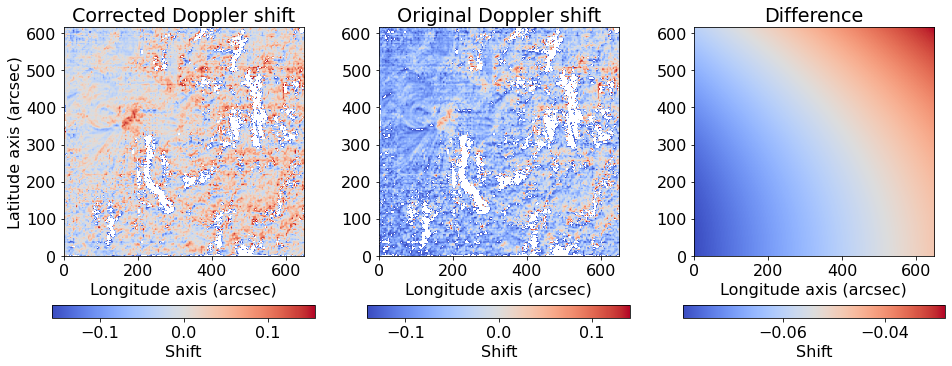

In [109]:
corr_doppler, listerr_lat, listerr_lon = shift_correction2nd(tot_cens[0][30:,50:330], True, True, False)